## **import**

In [1]:
from log_vec import *
from mycode import *
from data_process import *
from plot import *
import matplotlib.pyplot as plt

## Data preprocessing

In [1]:
data = DataProcess()

labels = np.array(data.log_label())
event_id = np.array(data.encode_event_ids())
x_sequence , y_true = data.make_train_seq_list()
x_test , y_test = data.make_test_seq_list()
warn_count, warn_index = data.count_warning_sequences(labels)

print(warn_index)
print(warn_count)
print(labels.shape)
print(event_id.shape)
print(x_test.shape, y_test.shape)
print(x_sequence.shape, y_true.shape)
print(x_test)
print(x_sequence)

#====================================
event_id_set = set(event_id)
event_size = len(event_id_set)
print(len(event_id_set)) #event_size


NameError: name 'DataProcess' is not defined

[0 0 1 ... 3 0 3]


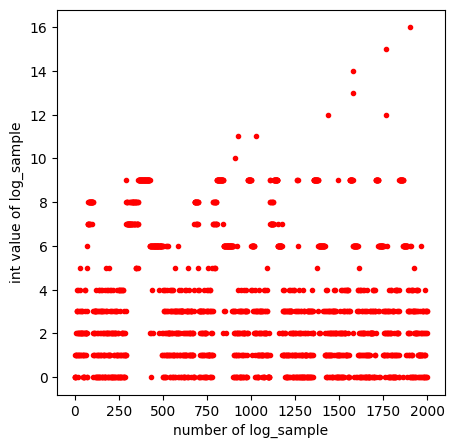

In [ ]:
myplot = MyPlot()
print(event_id)
myplot.sliding_window_data(event_id, labels)

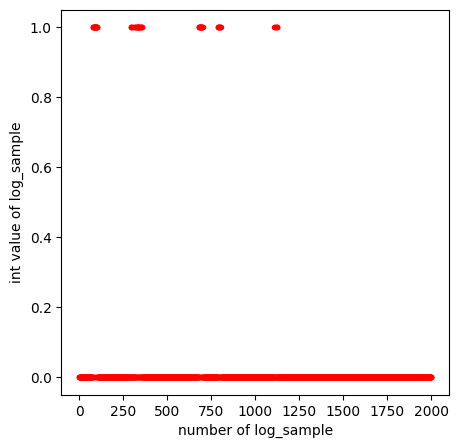

In [4]:
myplot.sliding_window_data(labels)

In [ ]:
embedding = Embedding(event_size, 16)
print(embedding.embedding_matrix.shape)

embedding_seq = [embedding.forward(seq) for seq in x_sequence]
print((np.array(embedding_seq)).shape)

embedding_test = [embedding.forward(seq) for seq in x_test]
embedding_test = np.array(embedding_test)
print(((embedding_test).shape))

(17, 16)
(1795, 10, 16)
(1990, 10, 16)


## Get_feature_matrix

- declare mymodel

In [ ]:
input_size = embedding.embedding_matrix.shape[1]
hidden_size = 32
concat_size = input_size + hidden_size

w_f = np.random.randn(hidden_size, concat_size)
b_f = np.zeros((hidden_size, 1))
w_i = np.random.randn(hidden_size, concat_size)
b_i = np.zeros((hidden_size, 1))
w_c = np.random.randn(hidden_size, concat_size)
b_c = np.zeros((hidden_size, 1))
w_o = np.random.randn(hidden_size, concat_size)
b_o = np.zeros((hidden_size, 1))

cell = LSTM_CELL(w_f, b_f, w_i, b_i, w_c, b_c, w_o, b_o)


    (1) h_list is feature matrix

In [ ]:
h_list = []

for seq in embedding_seq:
    h_prev = np.zeros((hidden_size, 1))
    c_prev = np.zeros((hidden_size, 1))

    for t in range(seq.shape[0]):
        x_t = seq[t].reshape(-1, 1)
        cell.get_concat_vector(h_prev, x_t)
        h_t, c_t = cell.forward(h_prev, x_t, c_prev)
        h_prev, c_prev = h_t, c_t
    
    h_list.append(h_t.flatten())

feature_matrix = np.array(h_list)
print(feature_matrix.shape)

(1795, 32)


/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/mycode.py:37: RuntimeWarning: divide by zero encountered in matmul
  value = (self.w_c @ self.concat_vector) + self.b_c
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/mycode.py:37: RuntimeWarning: overflow encountered in matmul
  value = (self.w_c @ self.concat_vector) + self.b_c
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/mycode.py:37: RuntimeWarning: invalid value encountered in matmul
  value = (self.w_c @ self.concat_vector) + self.b_c
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/mycode.py:27: RuntimeWarning: divide by zero encountered in matmul
  value = (self.w_f @ self.concat_vector) + self.b_f
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/mycode.py:27: RuntimeWarning: overflow encountered in matmul
  value = (self.w_f @ self.concat_vector) + self.b_f
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/mycode.py:27: Run

    (2) get_feature_vector

In [ ]:
test_set = embedding_test[:,:,:]
print(test_set.shape)

h2_list = []

for sample in test_set:
    h_prev = np.zeros((hidden_size, 1))
    c_prev = np.zeros((hidden_size, 1))

    for t in range(sample.shape[0]):
        x_t = sample[t].reshape(-1, 1)
        cell.get_concat_vector(h_prev, x_t)
        h_t, c_t = cell.forward(h_prev, x_t, c_prev)
        h_prev, c_prev = h_t, c_t
    
    h2_list.append(h_t.flatten())

feature_vectors = np.array(h2_list)
print(feature_vectors.shape)
    

(1990, 10, 16)
(1990, 32)


# Scaled

In [ ]:
from scaler import Scaler

scaler = Scaler()
scaled_feature = scaler.get_scaled_matrix(feature_matrix)
scaled_test = scaler.get_scaled_test(feature_vectors)
print(scaled_feature.shape, scaled_test.shape)

(1795, 32) (1990, 32)


# Train

In [ ]:
from autoencoder import Autoencoder

autoencoder = Autoencoder(feature_matrix.shape[1] , hidden_size)
autoencoder.train_data(scaled_feature)

/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/autoencoder.py:18: RuntimeWarning: divide by zero encountered in matmul
  z = self.W_enc @ x + self.b_enc
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/autoencoder.py:18: RuntimeWarning: overflow encountered in matmul
  z = self.W_enc @ x + self.b_enc
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/autoencoder.py:18: RuntimeWarning: invalid value encountered in matmul
  z = self.W_enc @ x + self.b_enc
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/autoencoder.py:23: RuntimeWarning: divide by zero encountered in matmul
  x_hat = self.W_dec @ z + self.b_dec
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/autoencoder.py:23: RuntimeWarning: overflow encountered in matmul
  x_hat = self.W_dec @ z + self.b_dec
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/autoencoder.py:23: RuntimeWarning: invalid value encountered in matmul
  x_hat 

In [ ]:
count = 0
for row in scaled_test:
    row = row.reshape(-1,1)
    new_loss , result = autoencoder.predict(row)
    if result == 'abnormal':
        count += 1
    print(f"Thrsehold = {autoencoder.threshold}")
    print(f"{result} (MSE: {new_loss:.4f})")
print(f"number of abnormal : {count}")

Thrsehold = 0.04218725386644263
normal (MSE: 0.0010)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0013)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0033)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0030)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0034)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0011)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0063)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0020)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0139)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0103)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0068)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0023)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0028)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0017)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0028)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0204)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0023)
Thrsehold = 0.04218725386644263
normal (MSE: 0.0075)
Thrsehold = 0.04218725386644263
normal (MSE: 0

/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/autoencoder.py:18: RuntimeWarning: divide by zero encountered in matmul
  z = self.W_enc @ x + self.b_enc
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/autoencoder.py:18: RuntimeWarning: overflow encountered in matmul
  z = self.W_enc @ x + self.b_enc
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/autoencoder.py:18: RuntimeWarning: invalid value encountered in matmul
  z = self.W_enc @ x + self.b_enc
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/autoencoder.py:23: RuntimeWarning: divide by zero encountered in matmul
  x_hat = self.W_dec @ z + self.b_dec
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/autoencoder.py:23: RuntimeWarning: overflow encountered in matmul
  x_hat = self.W_dec @ z + self.b_dec
/Users/taehayeong/Desktop/Git_workspace/Machine_learning/RNN_LSTM/autoencoder.py:23: RuntimeWarning: invalid value encountered in matmul
  x_hat 

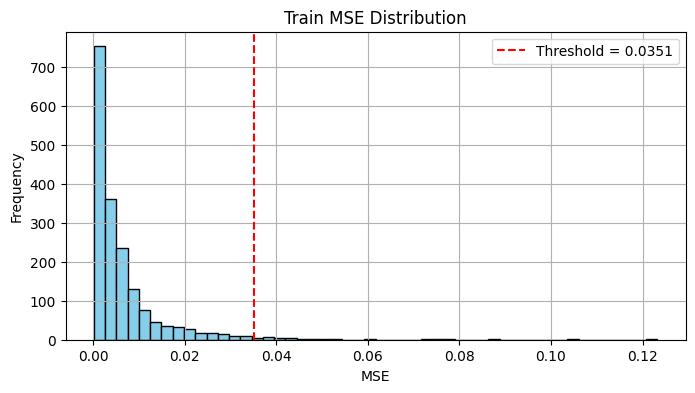

In [ ]:
mse_list = autoencoder.train_mse_list

plt.figure(figsize=(8, 4))
plt.hist(mse_list, bins=50, color='skyblue', edgecolor='k')
plt.axvline(autoencoder.threshold, color='red', linestyle='--', label=f'Threshold = {autoencoder.threshold:.4f}')
plt.title("Train MSE Distribution")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
autoencoder.threshold = 0.0351

count = 0
for row in scaled_test:
    row = row.reshape(-1,1)
    new_loss , result = autoencoder.predict(row)
    if result == 'abnormal':
        count += 1
    print(f"Thrsehold = {autoencoder.threshold}")
    print(f"{result} (MSE: {new_loss:.4f})")
print(f"number of abnormal : {count}")

Thrsehold = 0.0351
normal (MSE: 0.0010)
Thrsehold = 0.0351
normal (MSE: 0.0013)
Thrsehold = 0.0351
normal (MSE: 0.0033)
Thrsehold = 0.0351
normal (MSE: 0.0030)
Thrsehold = 0.0351
normal (MSE: 0.0034)
Thrsehold = 0.0351
normal (MSE: 0.0011)
Thrsehold = 0.0351
normal (MSE: 0.0063)
Thrsehold = 0.0351
normal (MSE: 0.0020)
Thrsehold = 0.0351
normal (MSE: 0.0139)
Thrsehold = 0.0351
normal (MSE: 0.0103)
Thrsehold = 0.0351
normal (MSE: 0.0068)
Thrsehold = 0.0351
normal (MSE: 0.0023)
Thrsehold = 0.0351
normal (MSE: 0.0028)
Thrsehold = 0.0351
normal (MSE: 0.0017)
Thrsehold = 0.0351
normal (MSE: 0.0028)
Thrsehold = 0.0351
normal (MSE: 0.0204)
Thrsehold = 0.0351
normal (MSE: 0.0023)
Thrsehold = 0.0351
normal (MSE: 0.0075)
Thrsehold = 0.0351
normal (MSE: 0.0033)
Thrsehold = 0.0351
normal (MSE: 0.0018)
Thrsehold = 0.0351
normal (MSE: 0.0080)
Thrsehold = 0.0351
normal (MSE: 0.0011)
Thrsehold = 0.0351
normal (MSE: 0.0035)
Thrsehold = 0.0351
normal (MSE: 0.0033)
Thrsehold = 0.0351
normal (MSE: 0.0036)
